# Notebook 01 - Analise exploratoria dos dados

Aqui vamos entender o que temos em maos: estrutura das tabelas, dados faltantes, e como a inadimplencia se distribui.

A variavel que queremos prever: pagamento com 5 ou mais dias de atraso em relacao ao vencimento.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_all_data
from src.feature_engineering import create_target
from src.config import FIGURES_DIR, DEFAULT_THRESHOLD_DAYS, DDD_REGIAO

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

print('Setup completo.')

Setup completo.


## 1. Carga dos dados

In [2]:
cadastral, info, pag_dev, pag_teste = load_all_data()

  Cadastral: 66 clientes PF descartados (foco em PJ)
  Dev: 219 transacoes PF descartadas
  Teste: 85 transacoes PF descartadas
  Info: 254 registros PF descartados
Cadastral:         1249 registros, 7 colunas
Info:             24147 registros, 4 colunas
Pagamentos Dev:   77195 registros, 7 colunas
Pagamentos Teste: 12190 registros, 6 colunas


## 2. Qualidade dos dados

### 2.1 Base cadastral

In [3]:
print(f'Shape: {cadastral.shape}')
print(f'\nDtypes:\n{cadastral.dtypes}')
print(f'\nNulos por coluna:\n{cadastral.isna().sum()}')
print(f'\nPercentual de nulos:\n{(cadastral.isna().mean() * 100).round(2)}')
print(f'\nID_CLIENTE unicos: {cadastral["ID_CLIENTE"].nunique()}')
print(f'Duplicatas: {cadastral.duplicated(subset=["ID_CLIENTE"]).sum()}')
cadastral.describe(include='all')

Shape: (1249, 7)

Dtypes:
ID_CLIENTE                      int64
DATA_CADASTRO          datetime64[ns]
DDD                           float64
SEGMENTO_INDUSTRIAL            object
DOMINIO_EMAIL                  object
PORTE                          object
CEP_2_DIG                      object
dtype: object

Nulos por coluna:
ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    210
SEGMENTO_INDUSTRIAL     17
DOMINIO_EMAIL           29
PORTE                   39
CEP_2_DIG                0
dtype: int64

Percentual de nulos:
ID_CLIENTE              0.00
DATA_CADASTRO           0.00
DDD                    16.81
SEGMENTO_INDUSTRIAL     1.36
DOMINIO_EMAIL           2.32
PORTE                   3.12
CEP_2_DIG               0.00
dtype: float64

ID_CLIENTE unicos: 1249
Duplicatas: 0


,ID_CLIENTE,DATA_CADASTRO,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
count,1.249000e+03,1249,1039.000000,1232,1220,1210,1249
unique,NaN,NaN,NaN,3,6,3,90
top,NaN,NaN,NaN,Serviços,YAHOO,MEDIO,13
freq,NaN,NaN,NaN,503,375,500,84
mean,4.648181e+18,2013-05-20 22:17:23.394715904,39.185756,NaN,NaN,NaN,NaN
min,8.784237e+15,2000-08-15 00:00:00,0.000000,NaN,NaN,NaN,NaN
25%,2.290083e+18,2011-02-14 00:00:00,16.000000,NaN,NaN,NaN,NaN
50%,4.717594e+18,2014-07-23 00:00:00,35.000000,NaN,NaN,NaN,NaN
75%,6.987943e+18,2018-09-19 00:00:00,62.000000,NaN,NaN,NaN,NaN
max,9.206031e+18,2021-07-18 00:00:00,99.000000,NaN,NaN,NaN,NaN


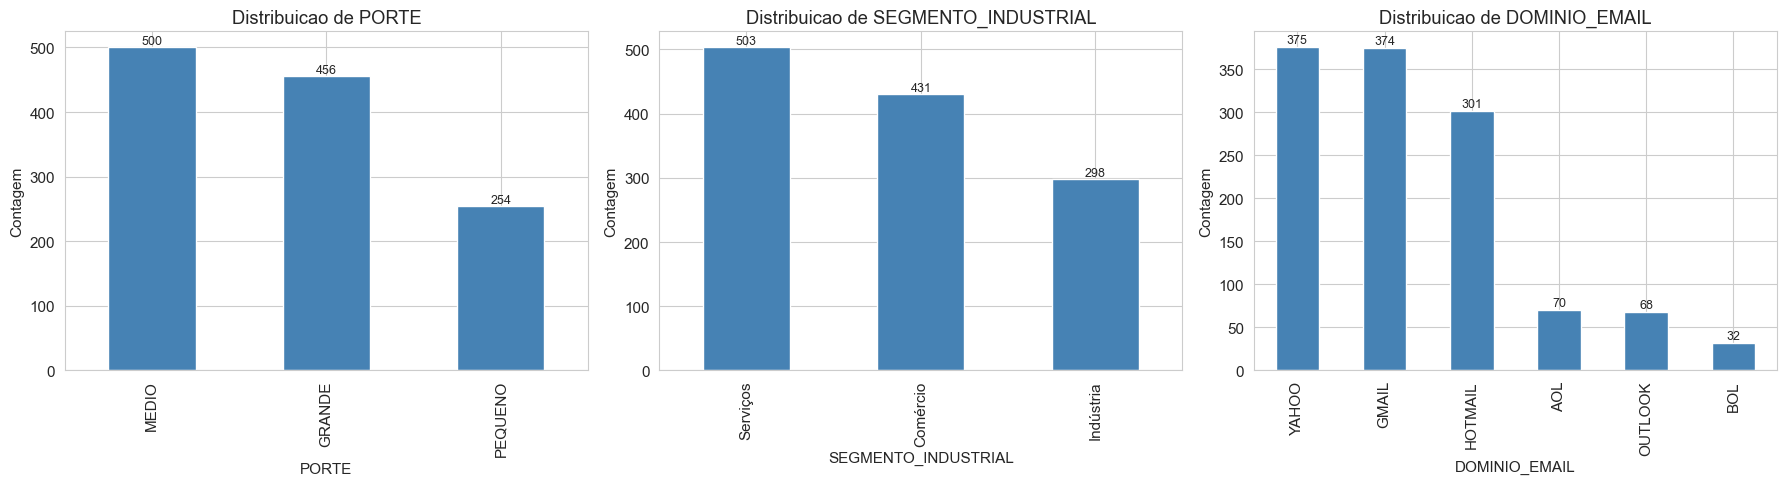

In [4]:
# Como as categoricas se distribuem
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes.flatten(), ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL']):
    counts = cadastral[col].value_counts()
    counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
    ax.set_title(f'Distribuicao de {col}')
    ax.set_ylabel('Contagem')
    for i, v in enumerate(counts.values):
        ax.text(i, v + 5, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cadastral_categoricas.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.2 Base info

In [5]:
print(f'Shape: {info.shape}')
print(f'\nDtypes:\n{info.dtypes}')
print(f'\nNulos por coluna:\n{info.isna().sum()}')
print(f'\nPercentual de nulos:\n{(info.isna().mean() * 100).round(2)}')
print(f'\nID_CLIENTE unicos: {info["ID_CLIENTE"].nunique()}')
print(f'SAFRA_REF range: {info["SAFRA_REF"].min()} a {info["SAFRA_REF"].max()}')
info.describe()

Shape: (24147, 4)

Dtypes:
ID_CLIENTE                     int64
SAFRA_REF             datetime64[ns]
RENDA_MES_ANTERIOR           float64
NO_FUNCIONARIOS              float64
dtype: object

Nulos por coluna:
ID_CLIENTE               0
SAFRA_REF                0
RENDA_MES_ANTERIOR     707
NO_FUNCIONARIOS       1239
dtype: int64

Percentual de nulos:
ID_CLIENTE            0.00
SAFRA_REF             0.00
RENDA_MES_ANTERIOR    2.93
NO_FUNCIONARIOS       5.13
dtype: float64

ID_CLIENTE unicos: 1249
SAFRA_REF range: 2018-09-01 00:00:00 a 2021-12-01 00:00:00


,ID_CLIENTE,SAFRA_REF,RENDA_MES_ANTERIOR,NO_FUNCIONARIOS
count,2.414700e+04,24147,2.344000e+04,22908.000000
mean,4.671428e+18,2020-05-04 21:31:37.726425600,2.912090e+05,118.898900
min,8.784237e+15,2018-09-01 00:00:00,1.050000e+02,60.000000
25%,2.347029e+18,2019-07-01 00:00:00,1.363428e+05,106.000000
50%,4.795153e+18,2020-06-01 00:00:00,2.433880e+05,118.000000
75%,7.067471e+18,2021-03-01 00:00:00,3.944862e+05,131.000000
max,9.206031e+18,2021-12-01 00:00:00,1.682759e+06,198.000000
std,2.668895e+18,NaN,2.110408e+05,18.288993


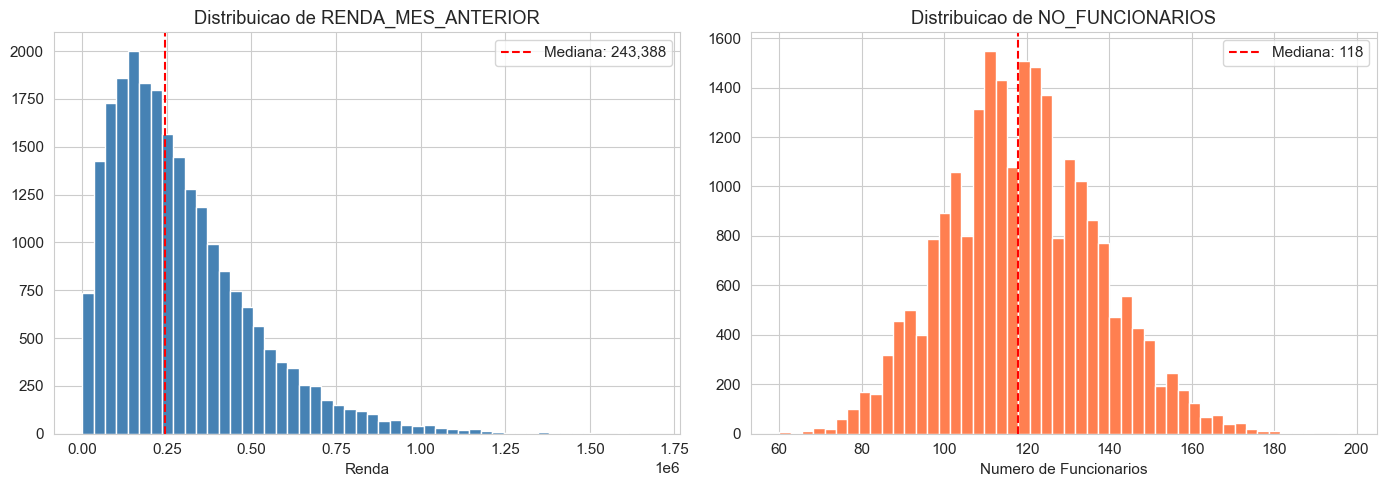

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Renda
renda_valida = info['RENDA_MES_ANTERIOR'].dropna()
axes[0].hist(renda_valida, bins=50, color='steelblue', edgecolor='white')
axes[0].set_title('Distribuicao de RENDA_MES_ANTERIOR')
axes[0].set_xlabel('Renda')
axes[0].axvline(renda_valida.median(), color='red', linestyle='--', label=f'Mediana: {renda_valida.median():,.0f}')
axes[0].legend()

# Funcionarios
func_valida = info['NO_FUNCIONARIOS'].dropna()
axes[1].hist(func_valida, bins=50, color='coral', edgecolor='white')
axes[1].set_title('Distribuicao de NO_FUNCIONARIOS')
axes[1].set_xlabel('Numero de Funcionarios')
axes[1].axvline(func_valida.median(), color='red', linestyle='--', label=f'Mediana: {func_valida.median():,.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'info_distribuicoes.png', dpi=150, bbox_inches='tight')
plt.show()

### 2.3 Pagamentos (desenvolvimento)

In [7]:
print(f'Shape: {pag_dev.shape}')
print(f'\nDtypes:\n{pag_dev.dtypes}')
print(f'\nNulos por coluna:\n{pag_dev.isna().sum()}')
print(f'\nID_CLIENTE unicos: {pag_dev["ID_CLIENTE"].nunique()}')
print(f'SAFRA_REF range: {pag_dev["SAFRA_REF"].min()} a {pag_dev["SAFRA_REF"].max()}')
print(f'\nTAXA valores unicos: {sorted(pag_dev["TAXA"].unique())}')
pag_dev.describe()

Shape: (77195, 7)

Dtypes:
ID_CLIENTE                         int64
SAFRA_REF                 datetime64[ns]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_PAGAMENTO            datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
dtype: object

Nulos por coluna:
ID_CLIENTE                   0
SAFRA_REF                    0
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
VALOR_A_PAGAR             1169
TAXA                         0
dtype: int64

ID_CLIENTE unicos: 1188
SAFRA_REF range: 2018-08-01 00:00:00 a 2021-06-01 00:00:00

TAXA valores unicos: [4.99, 5.99, 6.99, 8.99, 11.99]


,ID_CLIENTE,SAFRA_REF,DATA_EMISSAO_DOCUMENTO,DATA_PAGAMENTO,DATA_VENCIMENTO,VALOR_A_PAGAR,TAXA
count,7.719500e+04,77195,77195,77195,77195,7.602600e+04,77195.000000
mean,4.663477e+18,2020-01-19 01:39:30.044691968,2020-02-02 18:45:51.939892224,2020-02-25 21:35:57.201891328,2020-02-26 01:59:33.231427072,4.663752e+04,6.790142
min,8.784237e+15,2018-08-01 00:00:00,2018-08-17 00:00:00,2018-06-19 00:00:00,2017-11-27 00:00:00,1.000000e-01,4.990000
25%,2.369365e+18,2019-05-01 00:00:00,2019-05-21 00:00:00,2019-06-13 00:00:00,2019-06-12 00:00:00,1.878701e+04,5.990000
50%,4.817817e+18,2020-01-01 00:00:00,2020-01-27 00:00:00,2020-02-19 00:00:00,2020-02-18 00:00:00,3.479404e+04,5.990000
75%,6.969349e+18,2020-10-01 00:00:00,2020-10-27 00:00:00,2020-11-18 00:00:00,2020-11-18 00:00:00,6.097938e+04,6.990000
max,9.206031e+18,2021-06-01 00:00:00,2021-06-30 00:00:00,2021-11-24 00:00:00,2027-03-31 00:00:00,4.400000e+06,11.990000
std,2.665544e+18,NaN,NaN,NaN,NaN,4.646222e+04,1.798603


### 2.4 Pagamentos (teste)

In [8]:
print(f'Shape: {pag_teste.shape}')
print(f'\nDtypes:\n{pag_teste.dtypes}')
print(f'\nNulos por coluna:\n{pag_teste.isna().sum()}')
print(f'\nID_CLIENTE unicos: {pag_teste["ID_CLIENTE"].nunique()}')
print(f'SAFRA_REF range: {pag_teste["SAFRA_REF"].min()} a {pag_teste["SAFRA_REF"].max()}')

# Quantos clientes no teste nao aparecem no dev?
clientes_dev = set(pag_dev['ID_CLIENTE'].unique())
clientes_teste = set(pag_teste['ID_CLIENTE'].unique())
clientes_sem_hist = clientes_teste - clientes_dev
print(f'\nClientes no teste sem historico no dev: {len(clientes_sem_hist)}')

# Clientes no teste sem dados cadastrais
clientes_cadastral = set(cadastral['ID_CLIENTE'].unique())
clientes_sem_cadastro = clientes_teste - clientes_cadastral
print(f'Clientes no teste sem dados cadastrais: {len(clientes_sem_cadastro)}')

Shape: (12190, 6)

Dtypes:
ID_CLIENTE                         int64
SAFRA_REF                 datetime64[ns]
DATA_EMISSAO_DOCUMENTO    datetime64[ns]
DATA_VENCIMENTO           datetime64[ns]
VALOR_A_PAGAR                    float64
TAXA                             float64
dtype: object

Nulos por coluna:
ID_CLIENTE                  0
SAFRA_REF                   0
DATA_EMISSAO_DOCUMENTO      0
DATA_VENCIMENTO             0
VALOR_A_PAGAR             131
TAXA                        0
dtype: int64

ID_CLIENTE unicos: 927
SAFRA_REF range: 2021-07-01 00:00:00 a 2021-11-01 00:00:00

Clientes no teste sem historico no dev: 61
Clientes no teste sem dados cadastrais: 0


## 3. Variavel target

In [9]:
pag_dev = create_target(pag_dev)

n_default = pag_dev['TARGET'].sum()
n_total = len(pag_dev)
taxa_default = pag_dev['TARGET'].mean()

print(f'Total de transacoes: {n_total:,}')
print(f'Inadimplentes (5+ dias atraso): {n_default:,} ({taxa_default:.2%})')
print(f'Adimplentes: {n_total - n_default:,} ({1 - taxa_default:.2%})')
print(f'\nDesbalanceamento significativo: classe minoritaria ~{taxa_default:.1%}')

Total de transacoes: 77,195
Inadimplentes (5+ dias atraso): 5,392 (6.98%)
Adimplentes: 71,803 (93.02%)

Desbalanceamento significativo: classe minoritaria ~7.0%


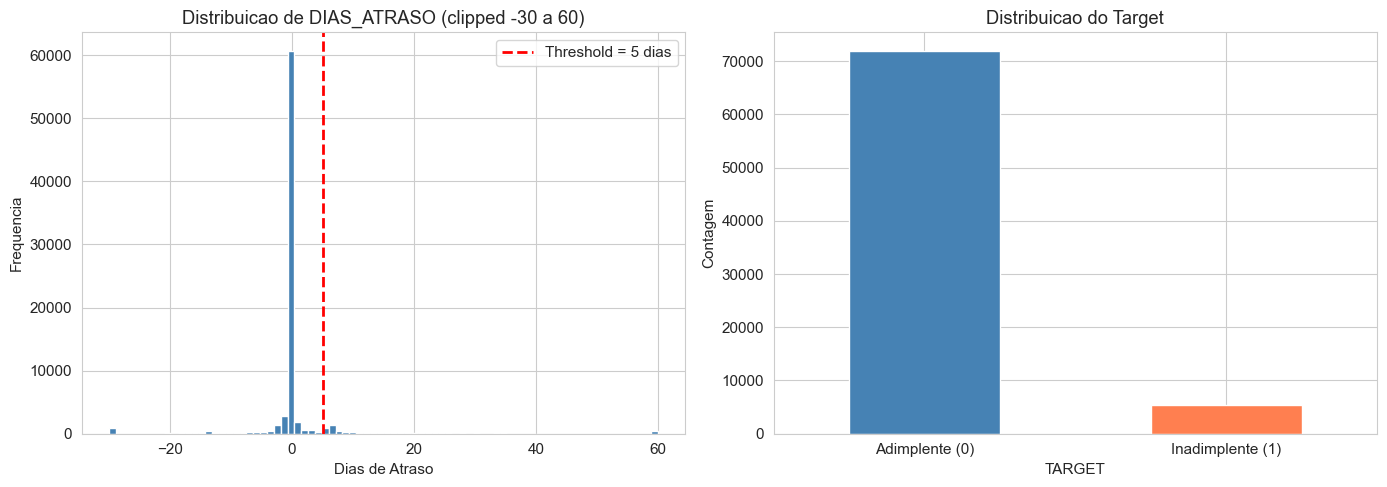

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribuicao de DIAS_ATRASO
axes[0].hist(pag_dev['DIAS_ATRASO'].clip(-30, 60), bins=80, color='steelblue', edgecolor='white')
axes[0].axvline(5, color='red', linestyle='--', linewidth=2, label=f'Threshold = {DEFAULT_THRESHOLD_DAYS} dias')
axes[0].set_title('Distribuicao de DIAS_ATRASO (clipped -30 a 60)')
axes[0].set_xlabel('Dias de Atraso')
axes[0].set_ylabel('Frequencia')
axes[0].legend()

# Balanceamento do target
pag_dev['TARGET'].value_counts().plot(kind='bar', ax=axes[1], color=['steelblue', 'coral'], edgecolor='white')
axes[1].set_title('Distribuicao do Target')
axes[1].set_xticklabels(['Adimplente (0)', 'Inadimplente (1)'], rotation=0)
axes[1].set_ylabel('Contagem')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'target_distribuicao.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Evolucao temporal

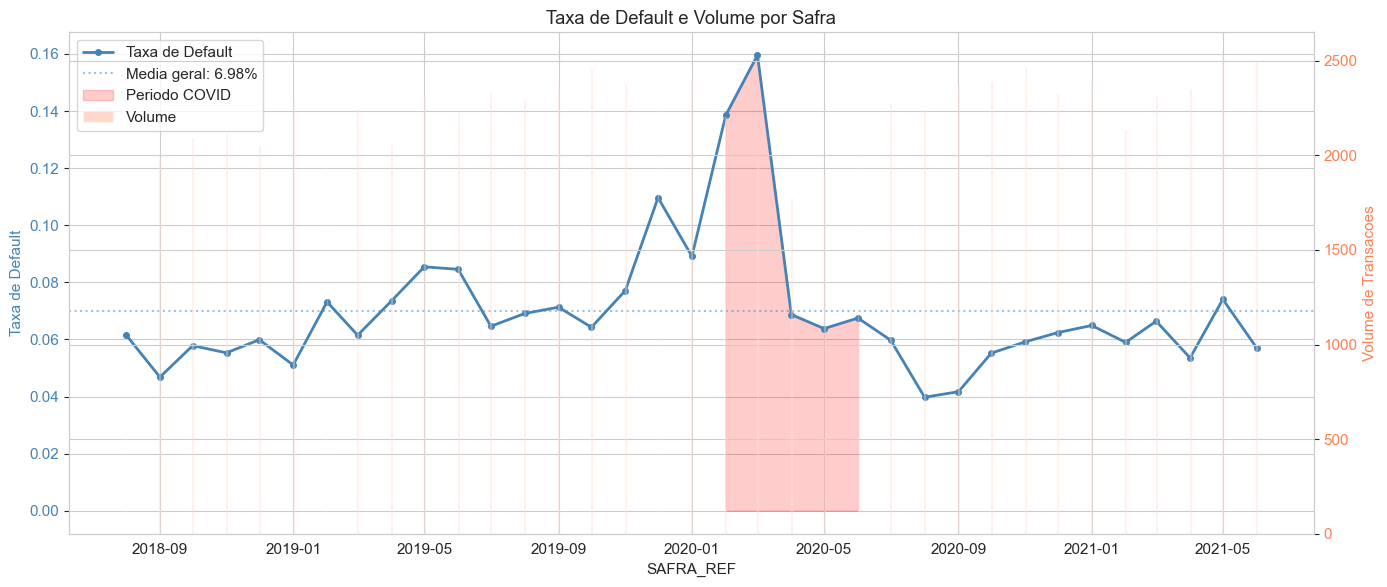


Periodo COVID (Fev-Jun 2020):
 SAFRA_REF  taxa_default  volume
2020-02-01      0.138573    2201
2020-03-01      0.159596    1980
2020-04-01      0.068732    1775
2020-05-01      0.063819    1896
2020-06-01      0.067515    2044


In [11]:
# Default ao longo do tempo
default_por_safra = pag_dev.groupby('SAFRA_REF').agg(
    taxa_default=('TARGET', 'mean'),
    volume=('TARGET', 'count'),
    n_default=('TARGET', 'sum')
).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 6))

# Taxa de default
color1 = 'steelblue'
ax1.plot(default_por_safra['SAFRA_REF'], default_por_safra['taxa_default'],
         'o-', color=color1, linewidth=2, markersize=4, label='Taxa de Default')
ax1.axhline(taxa_default, color=color1, linestyle=':', alpha=0.5, label=f'Media geral: {taxa_default:.2%}')
ax1.set_ylabel('Taxa de Default', color=color1)
ax1.set_xlabel('SAFRA_REF')
ax1.tick_params(axis='y', labelcolor=color1)

# Volume no eixo secundario
ax2 = ax1.twinx()
color2 = 'coral'
ax2.bar(default_por_safra['SAFRA_REF'], default_por_safra['volume'],
        alpha=0.3, color=color2, label='Volume')
ax2.set_ylabel('Volume de Transacoes', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Periodo COVID
covid_mask = (default_por_safra['SAFRA_REF'] >= '2020-02') & (default_por_safra['SAFRA_REF'] <= '2020-06')
ax1.fill_between(default_por_safra.loc[covid_mask, 'SAFRA_REF'],
                 0, default_por_safra.loc[covid_mask, 'taxa_default'],
                 alpha=0.2, color='red', label='Periodo COVID')

ax1.set_title('Taxa de Default e Volume por Safra')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'default_temporal.png', dpi=150, bbox_inches='tight')
plt.show()

# Pico COVID
print('\nPeriodo COVID (Fev-Jun 2020):')
print(default_por_safra[covid_mask][['SAFRA_REF', 'taxa_default', 'volume']].to_string(index=False))

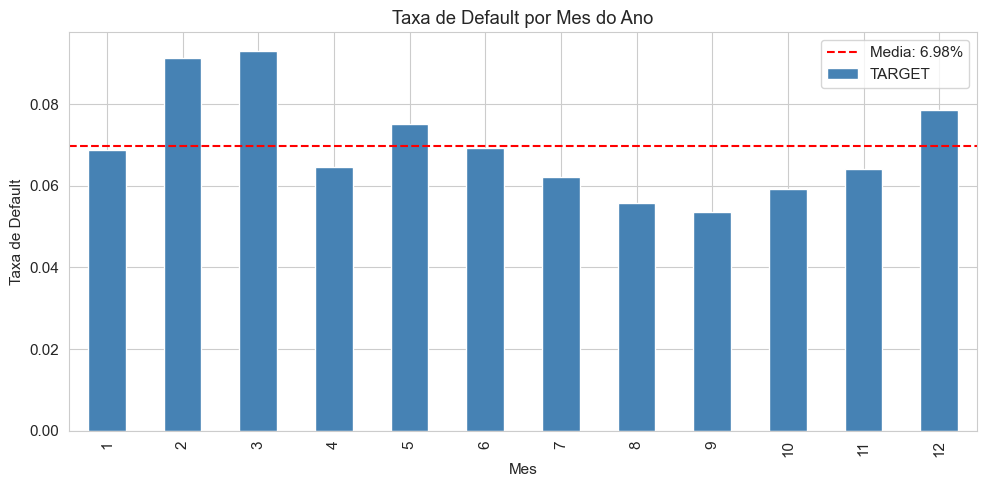

In [12]:
# Tem sazonalidade?
pag_dev['MES_ANO'] = pag_dev['SAFRA_REF'].dt.month

fig, ax = plt.subplots(figsize=(10, 5))
sazonalidade = pag_dev.groupby('MES_ANO')['TARGET'].mean()
sazonalidade.plot(kind='bar', ax=ax, color='steelblue', edgecolor='white')
ax.axhline(taxa_default, color='red', linestyle='--', label=f'Media: {taxa_default:.2%}')
ax.set_title('Taxa de Default por Mes do Ano')
ax.set_xlabel('Mes')
ax.set_ylabel('Taxa de Default')
ax.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'sazonalidade_default.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Relacao das features com o default

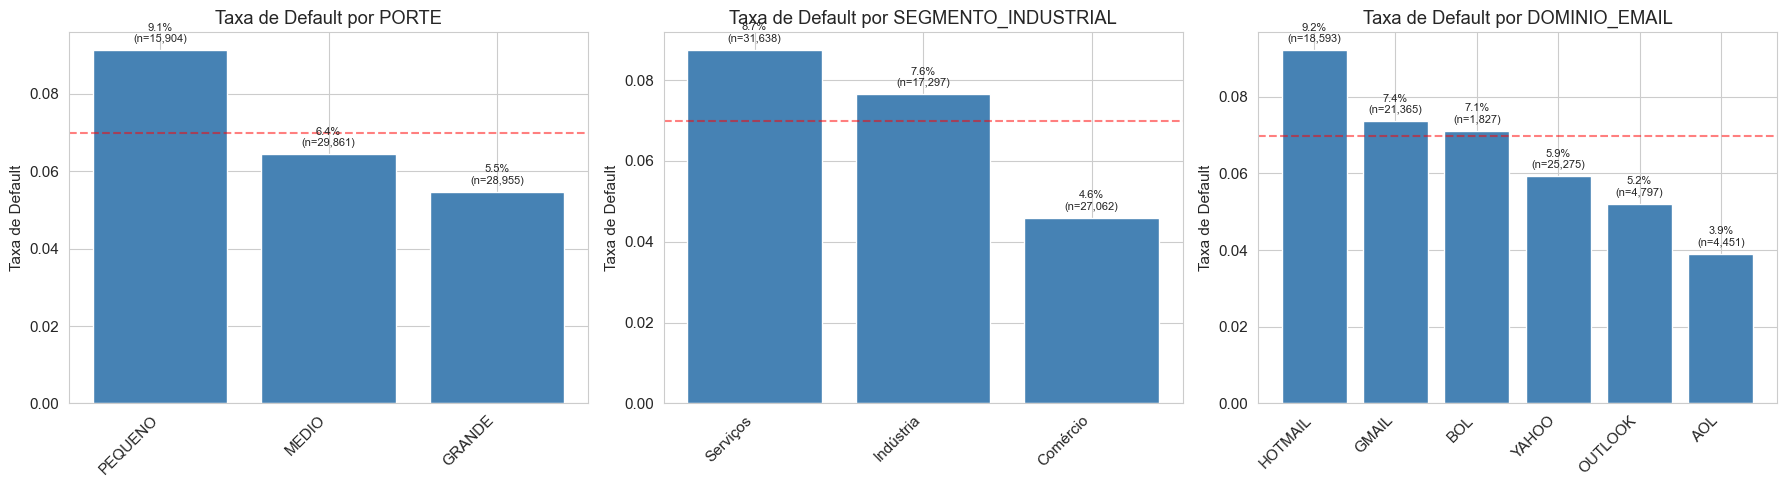

In [13]:
# Juntar com cadastral
pag_cadastral = pag_dev.merge(cadastral, on='ID_CLIENTE', how='left')

# Taxa de default por PORTE
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes.flatten(), ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL']):
    default_by = pag_cadastral.groupby(col).agg(
        taxa_default=('TARGET', 'mean'),
        volume=('TARGET', 'count')
    ).sort_values('taxa_default', ascending=False)

    bars = ax.bar(range(len(default_by)), default_by['taxa_default'],
                  color='steelblue', edgecolor='white')
    ax.set_xticks(range(len(default_by)))
    ax.set_xticklabels(default_by.index, rotation=45, ha='right')
    ax.set_title(f'Taxa de Default por {col}')
    ax.set_ylabel('Taxa de Default')
    ax.axhline(taxa_default, color='red', linestyle='--', alpha=0.5)

    for i, (v, n) in enumerate(zip(default_by['taxa_default'], default_by['volume'])):
        ax.text(i, v + 0.002, f'{v:.1%}\n(n={n:,})', ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'default_por_categorica.png', dpi=150, bbox_inches='tight')
plt.show()

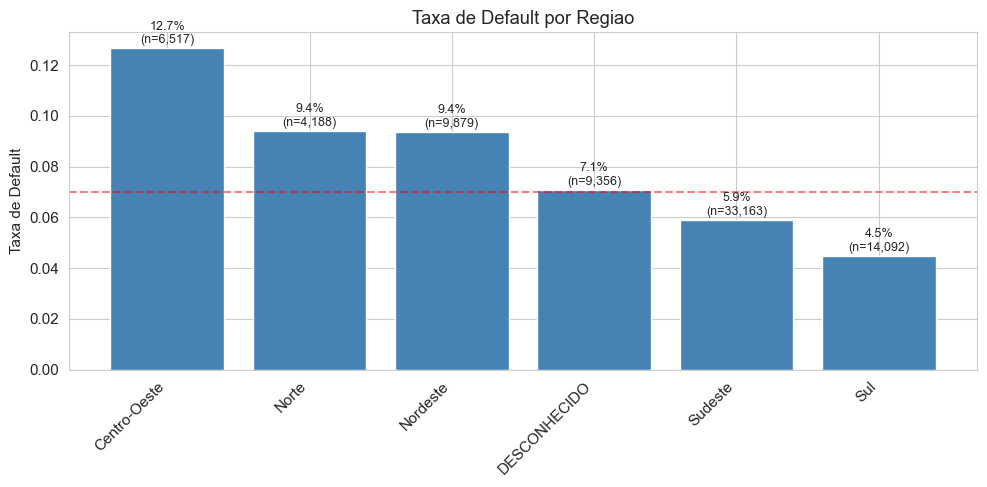

In [14]:
# DDD por regiao
pag_cadastral['DDD_REGIAO'] = pag_cadastral['DDD'].map(DDD_REGIAO).fillna('DESCONHECIDO')

fig, ax = plt.subplots(figsize=(10, 5))
default_regiao = pag_cadastral.groupby('DDD_REGIAO').agg(
    taxa_default=('TARGET', 'mean'),
    volume=('TARGET', 'count')
).sort_values('taxa_default', ascending=False)

bars = ax.bar(range(len(default_regiao)), default_regiao['taxa_default'],
              color='steelblue', edgecolor='white')
ax.set_xticks(range(len(default_regiao)))
ax.set_xticklabels(default_regiao.index, rotation=45, ha='right')
ax.set_title('Taxa de Default por Regiao')
ax.set_ylabel('Taxa de Default')
ax.axhline(taxa_default, color='red', linestyle='--', alpha=0.5)
for i, (v, n) in enumerate(zip(default_regiao['taxa_default'], default_regiao['volume'])):
    ax.text(i, v + 0.002, f'{v:.1%}\n(n={n:,})', ha='center', fontsize=9)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'default_por_regiao.png', dpi=150, bbox_inches='tight')
plt.show()

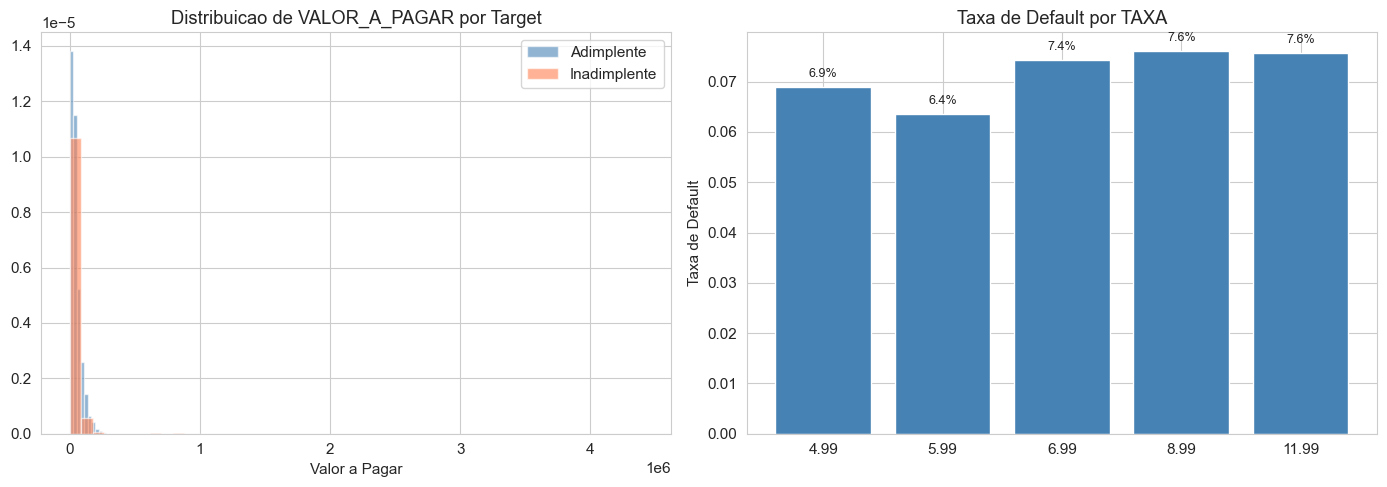

In [15]:
# Valor e taxa vs default
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Valor por target
for target_val, label, color in [(0, 'Adimplente', 'steelblue'), (1, 'Inadimplente', 'coral')]:
    subset = pag_dev[pag_dev['TARGET'] == target_val]['VALOR_A_PAGAR']
    axes[0].hist(subset, bins=50, alpha=0.6, color=color, label=label, density=True)
axes[0].set_title('Distribuicao de VALOR_A_PAGAR por Target')
axes[0].set_xlabel('Valor a Pagar')
axes[0].legend()

# Taxa vs default
default_taxa = pag_dev.groupby('TAXA')['TARGET'].mean().sort_index()
bars = axes[1].bar(range(len(default_taxa)), default_taxa.values, color='steelblue', edgecolor='white')
axes[1].set_xticks(range(len(default_taxa)))
axes[1].set_xticklabels([f'{t:.2f}' for t in default_taxa.index])
axes[1].set_title('Taxa de Default por TAXA')
axes[1].set_ylabel('Taxa de Default')
for i, v in enumerate(default_taxa.values):
    axes[1].text(i, v + 0.002, f'{v:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'valor_taxa_default.png', dpi=150, bbox_inches='tight')
plt.show()

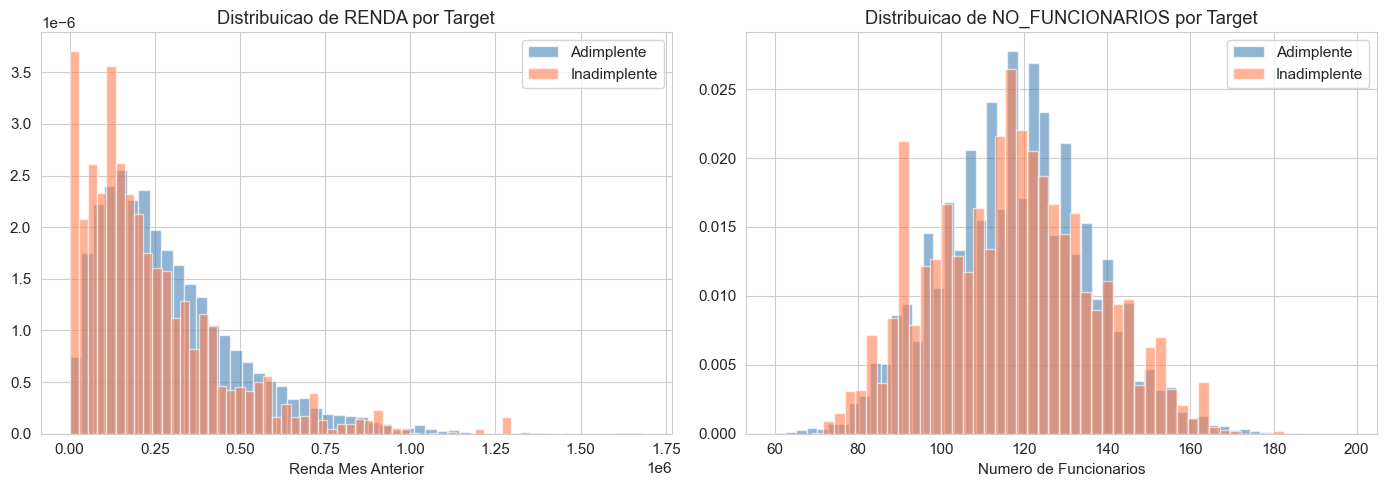

In [16]:
# Juntar com info
pag_info = pag_dev.merge(info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Renda por target
for target_val, label, color in [(0, 'Adimplente', 'steelblue'), (1, 'Inadimplente', 'coral')]:
    subset = pag_info[pag_info['TARGET'] == target_val]['RENDA_MES_ANTERIOR'].dropna()
    axes[0].hist(subset, bins=50, alpha=0.6, color=color, label=label, density=True)
axes[0].set_title('Distribuicao de RENDA por Target')
axes[0].set_xlabel('Renda Mes Anterior')
axes[0].legend()

# Funcionarios por target
for target_val, label, color in [(0, 'Adimplente', 'steelblue'), (1, 'Inadimplente', 'coral')]:
    subset = pag_info[pag_info['TARGET'] == target_val]['NO_FUNCIONARIOS'].dropna()
    axes[1].hist(subset, bins=50, alpha=0.6, color=color, label=label, density=True)
axes[1].set_title('Distribuicao de NO_FUNCIONARIOS por Target')
axes[1].set_xlabel('Numero de Funcionarios')
axes[1].legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'renda_func_default.png', dpi=150, bbox_inches='tight')
plt.show()

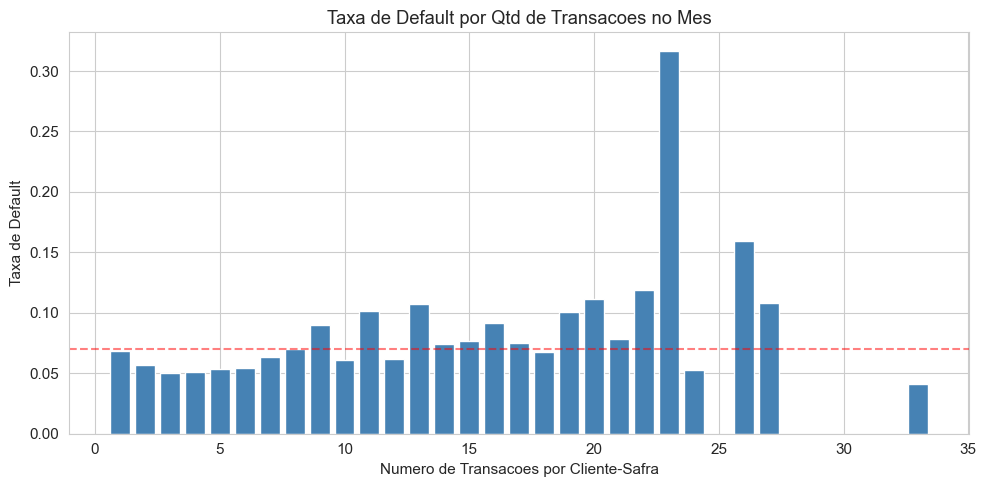

In [17]:
# Quantas transacoes no mes vs default
trans_por_cliente = pag_dev.groupby(['ID_CLIENTE', 'SAFRA_REF']).agg(
    qtd_transacoes=('TARGET', 'count'),
    taxa_default=('TARGET', 'mean')
).reset_index()

fig, ax = plt.subplots(figsize=(10, 5))
qtd_bins = trans_por_cliente.groupby('qtd_transacoes').agg(
    taxa_default=('taxa_default', 'mean'),
    volume=('taxa_default', 'count')
)
qtd_bins_filtered = qtd_bins[qtd_bins['volume'] >= 10]  # Filtrar bins com poucos dados
ax.bar(qtd_bins_filtered.index, qtd_bins_filtered['taxa_default'], color='steelblue', edgecolor='white')
ax.set_title('Taxa de Default por Qtd de Transacoes no Mes')
ax.set_xlabel('Numero de Transacoes por Cliente-Safra')
ax.set_ylabel('Taxa de Default')
ax.axhline(taxa_default, color='red', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'default_por_qtd_transacoes.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Correlacoes

In [18]:
# Correlacao de cada numerica com o target
numeric_cols = ['VALOR_A_PAGAR', 'TAXA', 'DIAS_ATRASO']
info_merged = pag_dev.merge(info, on=['ID_CLIENTE', 'SAFRA_REF'], how='left')

correlations = {}
for col in numeric_cols + ['RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS']:
    if col in info_merged.columns:
        valid = info_merged[[col, 'TARGET']].dropna()
        if len(valid) > 0:
            corr, pval = stats.pointbiserialr(valid['TARGET'], valid[col])
            correlations[col] = {'correlacao': corr, 'p_valor': pval}

corr_df = pd.DataFrame(correlations).T.sort_values('correlacao', key=abs, ascending=False)
print('Correlacoes Point-Biserial com TARGET:')
print(corr_df.to_string())

Correlacoes Point-Biserial com TARGET:
                    correlacao        p_valor
DIAS_ATRASO           0.216902   0.000000e+00
VALOR_A_PAGAR        -0.087201  3.228723e-128
RENDA_MES_ANTERIOR   -0.066498   1.587399e-70
TAXA                  0.012507   5.106497e-04
NO_FUNCIONARIOS      -0.010234   6.900380e-03


In [19]:
# Cramers V para categoricas
def cramers_v(x, y):
    """Calcula Cramers V entre duas variaveis categoricas."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0

cat_cols = ['PORTE', 'SEGMENTO_INDUSTRIAL', 'DOMINIO_EMAIL']
cramers = {}
for col in cat_cols:
    valid = pag_cadastral[[col, 'TARGET']].dropna()
    if len(valid) > 0:
        cramers[col] = cramers_v(valid[col], valid['TARGET'])

cramers_df = pd.Series(cramers).sort_values(ascending=False)
print('\nCramers V com TARGET:')
print(cramers_df.to_string())


Cramers V com TARGET:
SEGMENTO_INDUSTRIAL    0.072547
DOMINIO_EMAIL          0.060394
PORTE                  0.054868


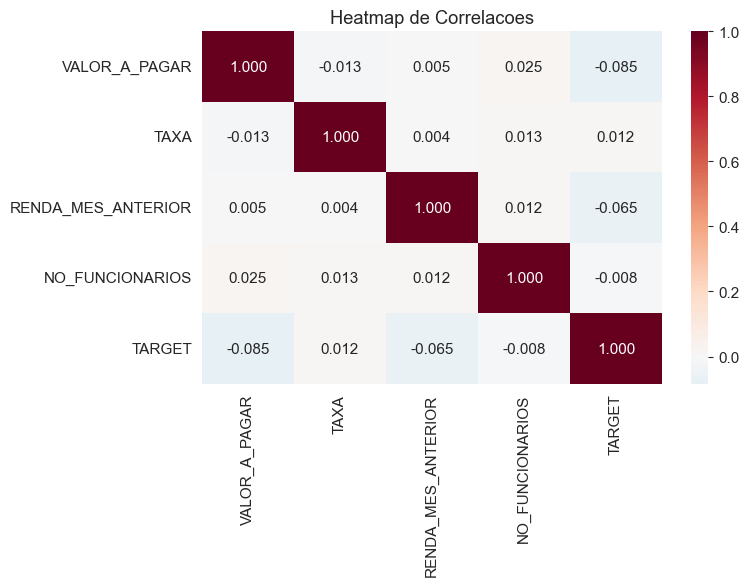

In [20]:
# Correlacoes entre as numericas
numeric_df = info_merged[['VALOR_A_PAGAR', 'TAXA', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS', 'TARGET']].dropna()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='RdBu_r', center=0, fmt='.3f', ax=ax)
ax.set_title('Heatmap de Correlacoes')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'heatmap_correlacoes.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. O que aprendemos

1. So ~7% das transacoes sao inadimplentes. O modelo precisa lidar com esse desbalanceamento.

2. Entre fevereiro e junho de 2020, a taxa de default saltou para 14-16%. Provavel efeito COVID. Vamos criar uma flag para esse periodo.

3. Taxas mais altas parecem estar associadas a mais default. Faz sentido: provavelmente clientes de maior risco ja recebem taxas maiores.

4. Descartamos os 66 clientes PF (pessoa fisica). Representam menos de 1% das transacoes e o comportamento de credito PF e PJ e muito diferente.

5. Renda tem 717 nulos e numero de funcionarios tem 1.252. Vamos precisar de flags de missing e imputer.

6. Tem 88 clientes no teste que nunca apareceram no dev. Para esses, so vamos ter features cadastrais e da transacao.

7. O historico de pagamento do cliente e provavelmente o melhor preditor. Quem atrasou antes tende a atrasar de novo.

### Na pratica:
- Periodos de crise precisam de monitoramento mais proximo
- Clientes com historico de atraso sao candidatos obvios para acoes preventivas de cobranca
- Segmentar por porte e regiao pode ajudar a direcionar esforcos